*   **Dataset**: CHB
*   **Processing**: mPLV

*   **Epochs**: 30  preictal+ictal
*   **Kernels**: WL, Spectral Decomposition, Random Walk
*   **Classifiers**: Decision Tree, Random Forest, SVC




In [1]:
!pip install mne
!pip install graphkit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 58.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import mne

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from os import listdir
from os.path import isfile, join
import tqdm
import multiprocessing
import networkx as nx
from collections import Counter, defaultdict
#from grakel.kernels import RandomWalk
from gklearn.utils.kernels import deltakernel, gaussiankernel, kernelproduct
import functools
from multiprocessing.pool import ThreadPool as Pool

from sklearn.decomposition import PCA,KernelPCA

import scipy.signal as sig
from scipy import linalg, stats
import seaborn as sns


import datetime
timestamp = datetime.datetime.now()
timestamp = timestamp.timestamp() * 1000
timestamp = str(timestamp)

In [3]:
def compPlv(epoch): #epoch->NCxNS
    nc,ns = epoch.shape
    plvk = np.zeros([nc,nc])
    data = sig.hilbert(epoch) #Compute the analytic signal, using the Hilbert transform.
    data = np.array(data)
    data = np.divide(data,abs(data))
    plvk = abs((np.inner(data[:,:], np.conj(data[:,:]))) / ns)
    return plvk


def savefigure(plt, filename, kernel=''):
    filepath = 'journal_imgs/' + 'chb_30_mPLV' + kernel + '_' + timestamp + '_' + filename +'.png'
    plt.savefig(filepath, bbox_inches='tight')

In [4]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir("drive/My Drive/Journal_Executions")

Mounted at /content/drive


In [5]:
#Repeat for CHB data
# fpath=['/content/gdrive/MyDrive/ProjectData/chb02']
# fpath="C:\\Users\\Owner\\OneDrive - University of New Brunswick\\Thesis\\Code\\graphKKE\\mPLV\\Data_EDF\\chb02"

ictalfp=[];ictalf=[];seizest=[];seizen=[];
preictalfp=[];preictalf=[];preseizest=[];preseizen=[];
interictalfp=[];interictalf=[];interseizest=[];interseizen=[];

SPH = [0,20]
SPHl = SPH[0]*60;
SPHu = SPH[1]*60;
ch=[0, 22];
MINSPHu=SPH[0];
MAXSPHl=SPH[1];

fpath = ['Data_EDF/chb02']

for f in fpath:
    print('f', f)
    print('f', f.split('/'))
    p=f.split('/')[-1]
    print('p', p)
    print('f', f)
    f1=f+'/'+p+'-summary.txt'
    print('p', f1)
    f2 = open(f1,'r+')
    string_list=f2.readlines()
    print(len(string_list))
    i=0;#flag=0
    fs = string_list[0].split()[-2]
    while (string_list[i][0]!='F'):
        i=i+1
    while (i<len(string_list)): #(flag!=1):
        if (string_list[i+3][len(string_list[i+3])-2]=='0'):
              i=i+5
        else:
            d=string_list[i].split(); ictal_fname= d[2]
            d=string_list[i+4].split(); st_t = int(d[3])
            d=string_list[i+5].split(); en_t = int(d[3])

          #CREATE ICTAL LIST
            ictalfp.append(f+'/'+ictal_fname);
            ictalf.append(ictal_fname);
            seizest.append(st_t);seizen.append(en_t)

          #CREATE PREICTAL as SPHu min = SPHu*60 sec before and upto the seizure start point if available,
          # else include from previous file

            if (st_t-SPHu>=0):
                pst=st_t-SPHu; pen=st_t-SPHl;
                preictalfp.append(f+'/'+ictal_fname);preictalf.append(ictal_fname);preseizest.append(pst);preseizen.append(pen)

            #ADD REMAINING FRONT DATA TO INTERICTAL
                if (st_t-SPHu >0):
                    intst=0; inten=st_t-SPHu; #DATA BEFORE PREICTAL
                    interictalfp.append(f+'/'+ictal_fname);interictalf.append(ictal_fname);interseizest.append(intst);interseizen.append(inten)
                #ADD REMAINING TAIL DATA TO INTERICTAL IF NEXT FILE IS NON-SEIZURE FILE
                if (string_list[i+10][len(string_list[i+3])-2]=='0'):
                    intst=int(en_t); inten=3600;#DATA AFTER SEIZURE END UPTO END of FILE
                    interictalfp.append(f+'/'+ictal_fname);interictalf.append(ictal_fname);interseizest.append(intst);interseizen.append(inten)

            else:
                #IF SUFFICIENT (30 min) PREICTAL DATA NOT AVAILABLE IN THE CURRENT FILE THEN PICK FROM CURRENT FILE and FROM PREVIOUS FILE IF AVAILABLE
                pst=0;  pen=st_t-SPHl;
                preictalfp.append(f+'/'+ictal_fname);preictalf.append(ictal_fname);preseizest.append(pst);preseizen.append(pen)
                remainlength =SPHu-st_t
                #IF PREVIOUS FILE IS NON-SEIZURE FILE PICK REMAINING secs without any further CHECK

                if (string_list[i-2][len(string_list[i+3])-2]=='0'):
                    d=string_list[i-5].split(); preictal_fname= d[2] #NAME OF PREVIOUS FILE
                    pst=3600-remainlength;  pen=3600; #Assuming each file MITPHYSIONET having 60 min recording- to be customized for other set-up
                    preictalfp.append(f+'/'+preictal_fname);preictalf.append(preictal_fname);preseizest.append(pst);preseizen.append(pen)

                      #ADD REMAINING FRONT DATA OF PREVIOUS NON SEIZURE FILE TO INTERICTAL
                    intst=0; inten=pst-1;#DATA BEFORE PREICTAL
                    interictalfp.append(f+'/'+preictal_fname);interictalf.append(preictal_fname);interseizest.append(intst);interseizen.append(inten)

                      #ADD REMAINING  DATA OF PREVIOUS ALL NON SEIZURE FILES TO INTERICTAL
                    j=i-7 #Last line of file preceding previous file
                    while(string_list[j][len(string_list[j])-2]=='0'): #will carry 0 only if it is Non-Seizure file
                        d=string_list[j-3].split(); interictal_fname= d[2] #NAME OF NON-SEIZURE FILE
                        intst=0; inten=3600;#ENTIRE DATA AS INTERICTAL
                        interictalfp.append(f+'/'+interictal_fname);interictalf.append(interictal_fname);interseizest.append(intst);interseizen.append(inten)
                        j=j-5

                else:
                  #OTHERWISE PICK FROM PREVIOUS (SEIZURE) FILE IF SUFFICIENT LENGTH AFTER SEIZURE END AVAILABLE-
                    d=string_list[i-7].split(); preictal_fname= d[2] #NAME OF PREVIOUS FILE
                    d=string_list[i-2].split(); enprev = int(d[3]) # #get seizure end time of previous file
                    available=3600-enprev
                    if (available >= remainlength):
                        pst=3600-remainlength;  pen=3600;
                        preictalfp.append(f+'/'+preictal_fname);preictalf.append(preictal_fname);preseizest.append(pst);preseizen.append(pen)

                        #ADD REMAINING DATA OF PREVIOUS SEIZURE FILE TO INTERICTAL
                        if (pst>enprev+1):
                            intst=enprev+1; inten=pst;#DATA BETWEEN SEIZURE END OF PREVIOUS FILE and THE Start of PREICTAL
                            interictalfp.append(f+'/'+preictal_fname);interictalf.append(preictal_fname);interseizest.append(intst);interseizen.append(inten)

                  #IF SUFFICIENT LENGTH NOT AVAILABLE, then RECORD THE AVAILABLE LENGTH AS MINSPH
                    else:
                        pst=enprev;  pen=3600; MINSPHu= SPH[1]-remainlength+ available
                        preictalfp.append(f+'/'+preictal_fname);preictalf.append(preictal_fname);preseizest.append(pst);preseizen.append(pen)
            i=i+7

    f2.close()


dict={'ictal_fpath':ictalfp, 'ictal_f':ictalf , 'seiz_st':seizest , 'seiz_en':seizen}
df = pd.DataFrame(dict)
#print('ICTAL\n', df)

dict={'Preictal_fpath':preictalfp, 'Preictal_f':preictalf , 'Preseiz_st':preseizest , 'Preseiz_en':preseizen}
dfpre = pd.DataFrame(dict)
#print('Preictal\n',dfpre)

print(len(df),len(dfpre))

#===================================================================================
#Data Selection with  Band- Pass Filter
band1= [0,5]; band2=[5, 8]; band3= [8,13]; band4= [13, 21]; band5= [21, 34]; band6= [34,100]

fs= 256; #st_f=band4[0]; en_f=band4[1];
st_f=0; en_f=100
train_data=[]; train_labels=[]

ictald=np.empty((22,0))
preictald=np.empty((22,0))
interictald=np.empty((22,0))

channel_names = None

#NOW USE ABOVE DATAFRAMES AND READ FILES TO FORM EPOCHS and TRAINING SET
#ICTAL
for i in range(0,len(df)):
    f=df['ictal_fpath'][i]
    raw = mne.io.read_raw_edf(f, verbose=False)
    raw.load_data() ## Filtering requires the data to be loaded to the memory
    d=raw.filter(None, 50., fir_design='firwin')#power noise notch filter at 50Hz
    d=raw.copy().filter(l_freq=st_f, h_freq=en_f)
    st=df['seiz_st'][i]; en=df['seiz_en'][i];
    ictald=np.concatenate((ictald,d._data[0:22, st*fs:en*fs]), axis=1)
#PREICTAL
for i in range(0,len(dfpre)):
    f=dfpre['Preictal_fpath'][i]
    raw = mne.io.read_raw_edf(f, verbose=False)
    raw.load_data() ## Filtering requires the data to be loaded to the memory

     # Get channel names from the raw object
    if channel_names is None:  # Store the names once
        channel_names = raw.info['ch_names']

    d=raw.filter(None, 50., fir_design='firwin') #power noise notch filter at 50Hz
    d=raw.copy().filter(l_freq=st_f, h_freq=en_f)
    st=dfpre['Preseiz_st'][i]; en=dfpre['Preseiz_en'][i];
    preictald=np.concatenate((preictald,d._data[0:22, st*fs:en*fs]), axis=1)


#Transform using z-score
from scipy import stats
ictald=stats.zscore(ictald, axis=1)
preictald=stats.zscore(preictald, axis=1)

print('Ictal: ', ictald.shape, '\nPreictal: ', preictald.shape)

#Create Train Data - 2s epochs from each category with corresponding label {1-preictal, 0- interictal}
fs=256
epochsize=2*fs

#Similarly create epochs for preictal
epochno =preictald.shape[1]//epochsize
preictalepochs = np.array(np.hsplit(preictald[:,0:epochno*epochsize],epochno ))
print('Preictal epochs:',epochno, '\n', preictalepochs.shape)

#Similarly create epochs for Ictal
epochno =ictald.shape[1]//epochsize
ictalepochs = np.array(np.hsplit(ictald[:,0:epochno*epochsize],epochno ))
print('Ictal epochs:',epochno, '\n', ictalepochs.shape)



f Data_EDF/chb02
f ['Data_EDF', 'chb02']
p chb02
f Data_EDF/chb02
p Data_EDF/chb02/chb02-summary.txt
215
3 4


<ipython-input-5-8a361cb74dea>:137: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(f, verbose=False)


Reading 0 ... 245503  =      0.000 ...   958.996 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 69 samples (0.270 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 35 samples (0.137 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-5-8a361cb74dea>:137: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(f, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 69 samples (0.270 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    8.5s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 35 samples (0.137 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   12.8s


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-5-8a361cb74dea>:137: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(f, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 69 samples (0.270 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.9s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 35 samples (0.137 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    8.3s


Reading 0 ... 245503  =      0.000 ...   958.996 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 69 samples (0.270 s)



<ipython-input-5-8a361cb74dea>:146: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(f, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 35 samples (0.137 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-5-8a361cb74dea>:146: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(f, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 69 samples (0.270 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 35 samples (0.137 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.1s


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-5-8a361cb74dea>:146: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(f, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 69 samples (0.270 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 35 samples (0.137 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


<ipython-input-5-8a361cb74dea>:146: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(f, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 69 samples (0.270 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 35 samples (0.137 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.2s


Ictal:  (22, 44032) 
Preictal:  (22, 921600)
Preictal epochs: 1800 
 (1800, 22, 512)
Ictal epochs: 86 
 (86, 22, 512)


In [6]:
fs=256
num_channels=preictalepochs.shape[1]

nanct=0
NEpoch=30

adj_matrix = np.zeros((NEpoch*2, num_channels, num_channels))
labels=np.zeros(NEpoch*2)

k=0
for i in np.arange(0,NEpoch):
    epoch = preictalepochs[i,:,:] #channel_data[:,3*i*fs:3*(i+1)*fs]
    cor_mat = compPlv(epoch) # np.corrcoef(epoch)#replace with mPLV compPlv(epoch) #
    if(np.isnan(cor_mat).any()):
        nanct=nanct+1
        continue
    adj_matrix[k] = cor_mat
    #data[k]=cor_mat.flatten()
    labels[k]=0
    k=k+1

nanct=0
NEpoch=30

for i in np.arange(0,NEpoch):
    epoch = ictalepochs[i,:,:] #channel_data[:,3*i*fs:3*(i+1)*fs]
    cor_mat = compPlv(epoch) # np.corrcoef(epoch)#replace with mPLV
    if(np.isnan(cor_mat).any()):
        nanct=nanct+1
        continue
    adj_matrix[k] = cor_mat
    #data[k]=cor_mat.flatten()
    labels[k]=1
    k=k+1

#Now Binarize Adjacency matrices before feeding for graph preparation
for i in np.arange(0,k):
    th=np.percentile(adj_matrix[i].flatten(),25)
    adj_matrix[i][adj_matrix[i]<th]=0
    adj_matrix[i][adj_matrix[i]>=th]=1

print(adj_matrix.shape)
adj_matrix= adj_matrix.astype(int)

(60, 22, 22)


In [7]:
channel_names

['FP1-F7',
 'F7-T7',
 'T7-P7',
 'P7-O1',
 'FP1-F3',
 'F3-C3',
 'C3-P3',
 'P3-O1',
 'FP2-F4',
 'F4-C4',
 'C4-P4',
 'P4-O2',
 'FP2-F8',
 'F8-T8',
 'T8-P8-0',
 'P8-O2',
 'FZ-CZ',
 'CZ-PZ',
 'P7-T7',
 'T7-FT9',
 'FT9-FT10',
 'FT10-T8',
 'T8-P8-1']

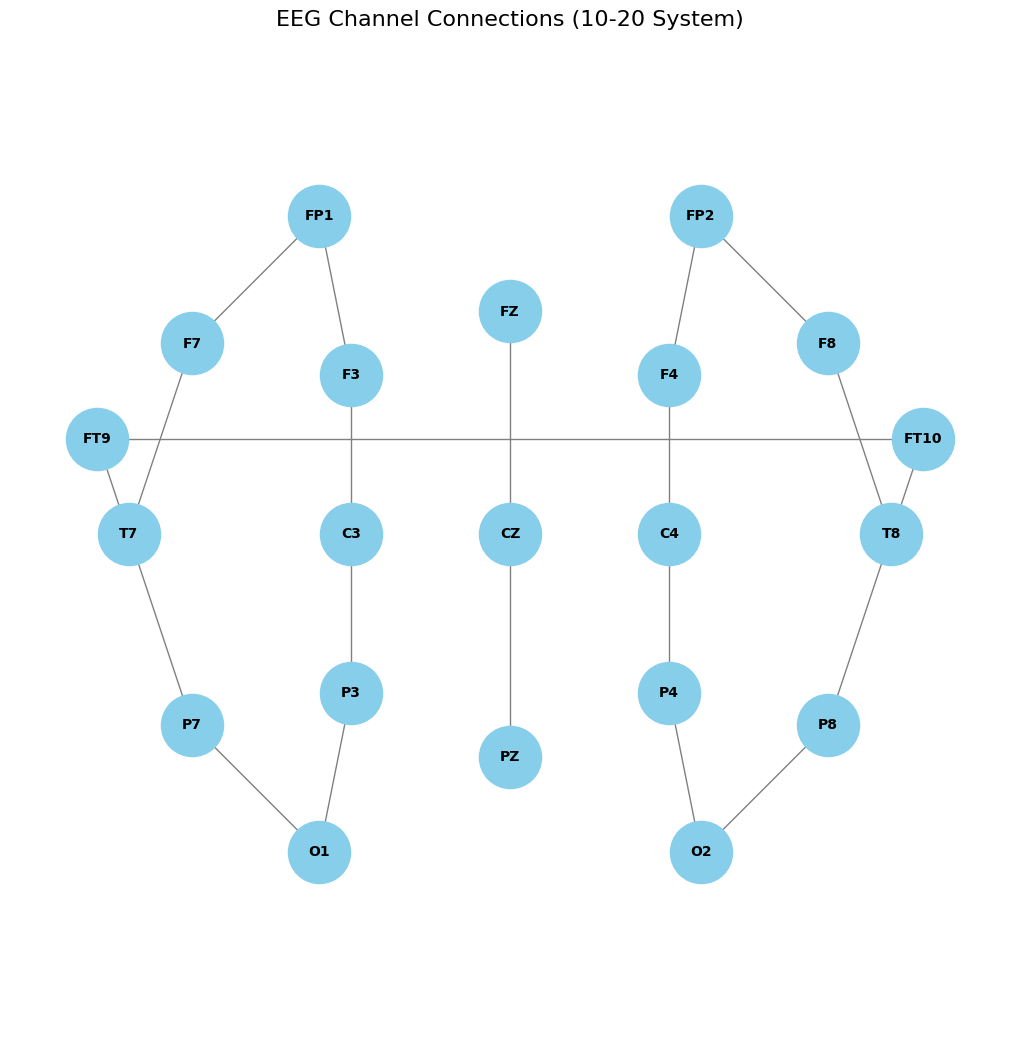

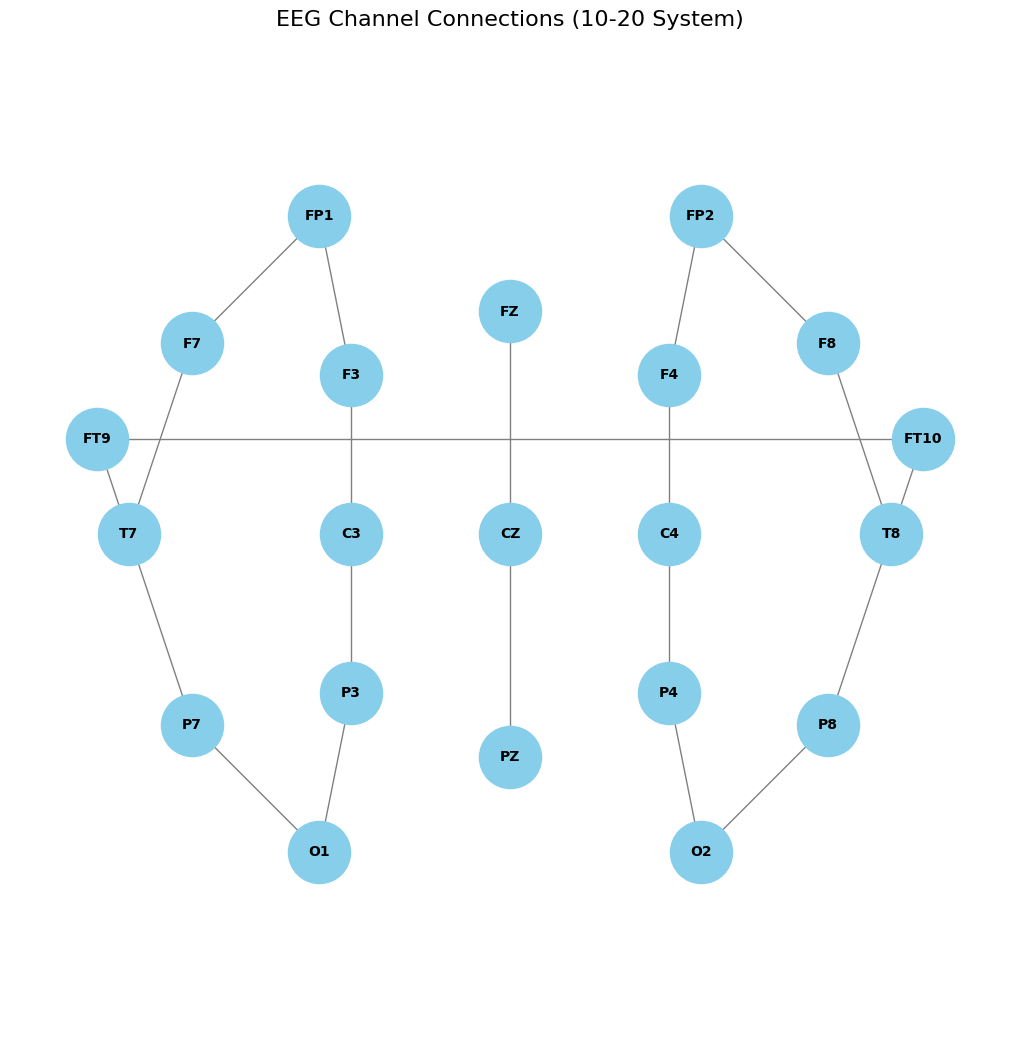

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx

# Channel connections
channels = [
    'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1',
    'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
    'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2',
    'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2',
    'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9',
    'FT9-FT10', 'FT10-T8', 'T8-P8-1'
]

# Electrode positions (simplified 2D positions for 10-20 system)
positions = {
    'FP1': (-0.6, 1.0), 'FP2': (0.6, 1.0), 'F7': (-1.0, 0.6), 'F8': (1.0, 0.6),
    'F3': (-0.5, 0.5), 'F4': (0.5, 0.5), 'C3': (-0.5, 0.0), 'C4': (0.5, 0.0),
    'P3': (-0.5, -0.5), 'P4': (0.5, -0.5), 'O1': (-0.6, -1.0), 'O2': (0.6, -1.0),
    'T7': (-1.2, 0.0), 'T8': (1.2, 0.0), 'P7': (-1.0, -0.6), 'P8': (1.0, -0.6),
    'FZ': (0.0, 0.7), 'CZ': (0.0, 0.0), 'PZ': (0.0, -0.7), 'FT9': (-1.3, 0.3),
    'FT10': (1.3, 0.3), 'T8-P8-0': (1.0, -0.6), 'T8-P8-1': (1.0, -0.6),
}

# Create a graph to represent the connections
G = nx.Graph()

# Add edges to the graph
for ch in channels:
    nodes = ch.split('-')
    G.add_edge(nodes[0], nodes[1])

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_size=2000,
    node_color="skyblue",
    font_size=10,
    font_weight="bold",
    edge_color="gray"
)

# Add a title
plt.title("EEG Channel Connections (10-20 System)", fontsize=16)
plt.axis("equal")
plt.show()

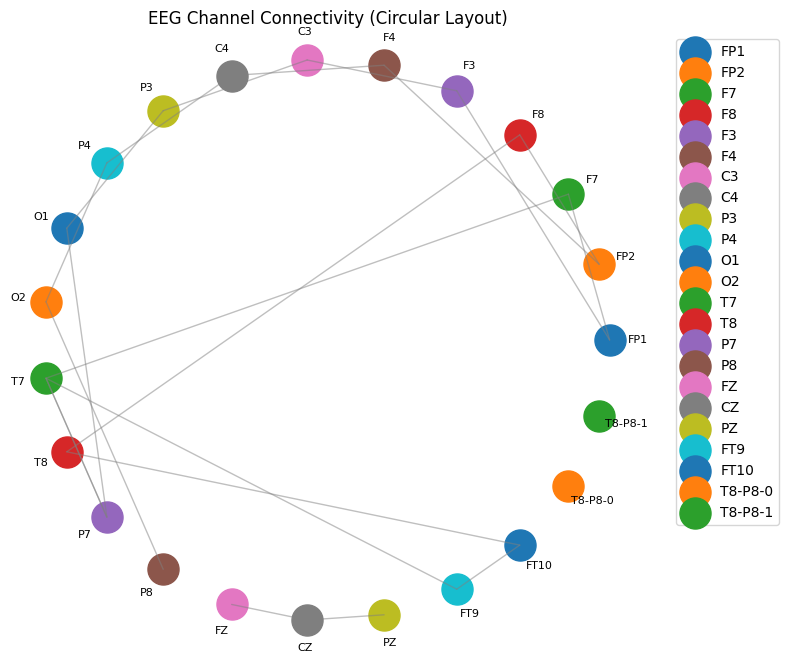

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

# Define channel positions around a circle
theta = np.linspace(0, 2 * np.pi, len(positions), endpoint=False)
positions_circle = {ch: (np.cos(t), np.sin(t)) for ch, t in zip(positions.keys(), theta)}

# Plot
plt.figure(figsize=(8, 8))
for ch, pos in positions_circle.items():
    plt.scatter(*pos, s=500, label=ch)
    plt.text(pos[0] * 1.1, pos[1] * 1.1, ch, ha="center", va="center", fontsize=8)

# Draw connections
for ch in channels:
    src, tgt = ch.rsplit('-', 1)
    if src in positions_circle and tgt in positions_circle:
        src_pos = positions_circle[src]
        tgt_pos = positions_circle[tgt]
        con = ConnectionPatch(src_pos, tgt_pos, "data", "data", color="gray", alpha=0.5)
        plt.gca().add_artist(con)

plt.title("EEG Channel Connectivity (Circular Layout)")
plt.axis("off")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [16]:
preictald.shape

ictald.shape

(22, 44032)

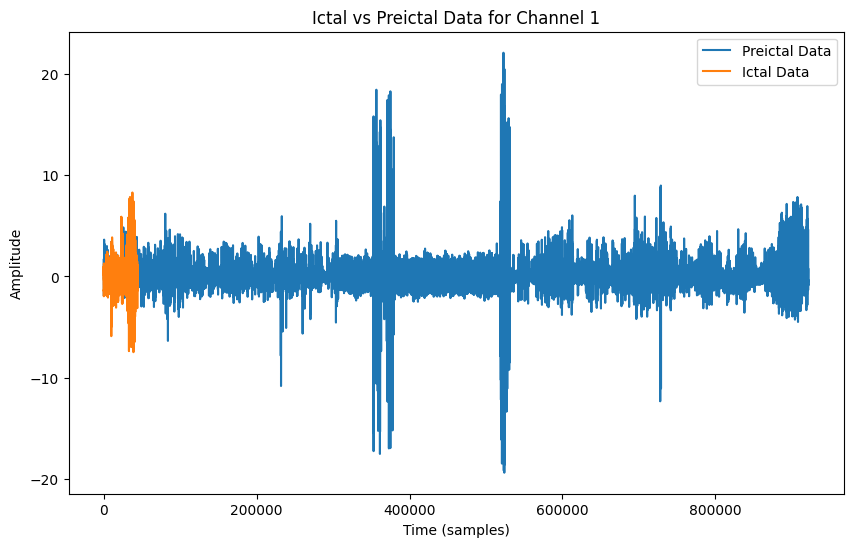

In [17]:
# Plot overlay of preictal and ictal data for a specific channel
plt.figure(figsize=(10, 6))
plt.plot(preictald[0, :], label="Preictal Data")
plt.plot(ictald[21, :], label="Ictal Data")
plt.title('Ictal vs Preictal Data for Channel 1')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

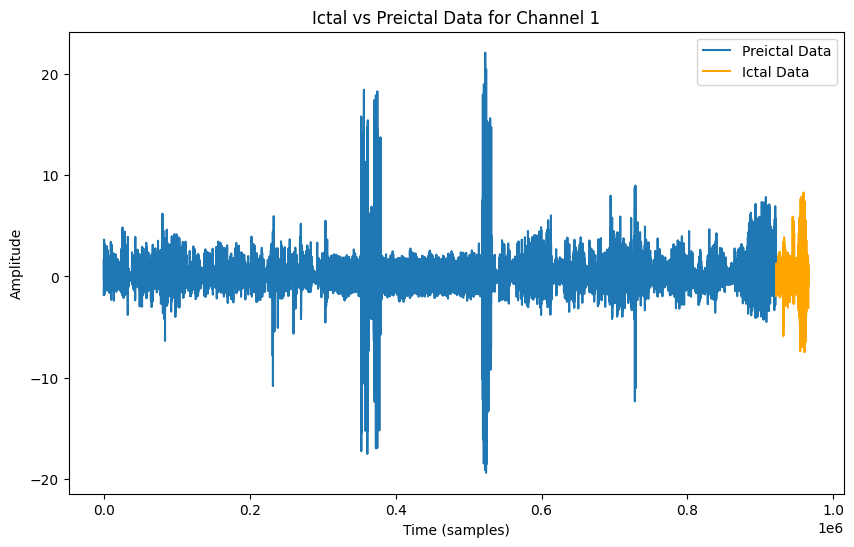

In [19]:
# Concatenate preictal and ictal data in the correct order
combined_data = np.concatenate((preictald[0, :], ictald[21, :]), axis=0)

# Generate the corresponding time axis
time_axis = np.arange(combined_data.shape[0])

# Plot the reordered data
plt.figure(figsize=(10, 6))
plt.plot(time_axis[:preictald.shape[1]], preictald[0, :], label="Preictal Data")
plt.plot(time_axis[preictald.shape[1]:], ictald[21, :], label="Ictal Data", color='orange')
plt.title('Ictal vs Preictal Data for Channel 1')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the adjacency matrix for a preictal epoch
plt.figure(figsize=(8, 6))
sns.heatmap(adj_matrix[00], cmap='coolwarm', annot=False)
plt.title("Adjacency Matrix (Preictal Epoch)")
plt.show()

# Plot the adjacency matrix for an ictal epoch
plt.figure(figsize=(8, 6))
sns.heatmap(adj_matrix[30], cmap='coolwarm', annot=False)
plt.title("Adjacency Matrix (Ictal Epoch)")
plt.show()

In [16]:
import numpy as np
from matplotlib import pyplot as plt

num_nodes = adj_matrix[30].shape[0]
theta = np.linspace(0, 2 * np.pi, num_nodes, endpoint=False)

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if adj_matrix[30][i, j] > 0.5:  # Threshold for connectivity
            ax.plot([theta[i], theta[j]], [1, 1], 'r-', alpha=0.7)

ax.set_xticks(theta)
ax.set_xticklabels(range(num_nodes))
plt.title("Circular Connectivity Plot (Ictal Epoch)")
plt.show()

In [17]:
# Generate shuffle indices for the first axis

print('labels::::', labels)
print('adj_matrix::::', adj_matrix.shape)
shuffle_indices = np.random.permutation(adj_matrix.shape[0])

print('shuffle_indices::::', shuffle_indices)
# Shuffle the array along the first axis using the generated indices
# adj_matrix = adj_matrix[shuffle_indices]
# labels=labels[shuffle_indices]

print('labels::::', labels)
print('adj_matrix::::', adj_matrix.shape)

labels:::: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
adj_matrix:::: (60, 22, 22)
shuffle_indices:::: [59 41  5 45  8 29 19 26 39 58 27 16 54 53  2  0  6 33 46 42 35 40 22  1
 57 11 12 18  3 10 23 43 14 28 21 51 38  7 37 55 15 31 44 49 56 50 13 25
 32 34  9 17 52 24 20 36 47  4 48 30]
labels:::: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
adj_matrix:::: (60, 22, 22)


In [18]:
#adj_matrix = np.random.randint(0, 100, size=(20, 20, 20))#datafile
#adj_matrix computed above
num_nodes = adj_matrix.shape[0]
node_labels = list(range(1, num_nodes+1))
graphs = []

for graph in adj_matrix:
    graph = nx.from_numpy_array(graph)
    mapping = {i: label for i, label in enumerate(node_labels)}
    graph = nx.relabel_nodes(graph, mapping)
    graphs.append(graph)


from gklearn.kernels.weisfeilerLehmanKernel import weisfeilerlehmankernel
kernel_matrix = weisfeilerlehmankernel(
    graphs,
    node_label='atom',
    edge_label='bond_type',
    height=3,
    base_kernel='subtree',
    parallel=None,
    n_jobs=None,
    verbose=True)
kernel = 'WL'


'''

from gklearn.kernels import SpectralDecomposition
graph_kernel = SpectralDecomposition(
    ds_infos=graphs,
    weight=1e-1,
    p=None,
    q=None,
    edge_weight=None,
    sub_kernel='exp'
)
kernel = 'SD'
kernel_matrix = graph_kernel.compute(
    graphs,
    parallel=None,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)



from gklearn.kernels.randomWalkKernel import randomwalkkernel
from gklearn.utils.kernels import deltakernel, gaussiankernel, kernelproduct
import functools
import multiprocessing

kernel = 'RW'
mixkernel = functools.partial(kernelproduct, deltakernel, gaussiankernel)
sub_kernels = [{'symb': deltakernel, 'nsymb': gaussiankernel, 'mix': mixkernel}]
sub_kernel = ['geo', 'exp']
compute_method = 'conjugate'

kernel = 'RandomWalk'
kernel_matrix = randomwalkkernel(
			graphs,
			compute_method=compute_method,
			weight=1e-3,
			p=None,
			q=None,
			edge_weight=None,
			node_kernels=sub_kernels,
			edge_kernels=sub_kernels,
			node_label='atom',
			edge_label='bond_type',
			sub_kernel=sub_kernel,
			n_jobs=multiprocessing.cpu_count(),
			verbose=True
		)
'''



 --- Weisfeiler-Lehman subtree kernel matrix of size 60 built in 0.24147987365722656 seconds ---


"\n\nfrom gklearn.kernels import SpectralDecomposition\ngraph_kernel = SpectralDecomposition(\n    ds_infos=graphs,\n    weight=1e-1,\n    p=None,\n    q=None,\n    edge_weight=None,\n    sub_kernel='exp'\n)\nkernel = 'SD'\nkernel_matrix = graph_kernel.compute(\n    graphs,\n    parallel=None,\n    n_jobs=multiprocessing.cpu_count(),\n    verbose=True\n)\n\n\n\nfrom gklearn.kernels.randomWalkKernel import randomwalkkernel\nfrom gklearn.utils.kernels import deltakernel, gaussiankernel, kernelproduct\nimport functools\nimport multiprocessing\n\nkernel = 'RW'\nmixkernel = functools.partial(kernelproduct, deltakernel, gaussiankernel)\nsub_kernels = [{'symb': deltakernel, 'nsymb': gaussiankernel, 'mix': mixkernel}]\nsub_kernel = ['geo', 'exp']\ncompute_method = 'conjugate'\n\nkernel = 'RandomWalk'\nkernel_matrix = randomwalkkernel(\n\t\t\tgraphs,\n\t\t\tcompute_method=compute_method,\n\t\t\tweight=1e-3,\n\t\t\tp=None,\n\t\t\tq=None,\n\t\t\tedge_weight=None,\n\t\t\tnode_kernels=sub_kernels,\

In [19]:
kpca = KernelPCA(kernel='rbf', gamma=1)
gram_kpca = kpca.fit_transform(kernel_matrix[0])

X=gram_kpca
y=labels

print('X VALUE::::::', X.shape)
print('y VALUE::::::::::::', len(y))

print("Feature Variability:", np.var(X, axis=0))
print("Label Distribution:", np.unique(y, return_counts=True))
print("Explained Variance (All Components):", kpca.eigenvalues_)

# import matplotlib.pyplot as plt
# plt.scatter(X[:, 0], np.zeros_like(X[:, 0]), c=y, cmap='viridis')
# plt.colorbar()
# plt.title("Feature Distribution After Kernel PCA")
# # plt.show()
# savefigure(plt, 'feature_distribution', kernel)

X VALUE:::::: (60, 59)
y VALUE:::::::::::: 60
Feature Variability: [0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667]
Label Distribution: (array([0., 1.]), array([30, 30]))
Explained Variance (All Components): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [20]:
print('Kernel:::', kernel)

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

# Define the parameter grids for each model
param_grid_svc = {
  'C': [0.01, 0.1, 1, 10, 100],
  'kernel': ['linear', 'rbf', 'poly'],
  'gamma': ['scale', 'auto'],
  'class_weight': ['balanced', None]
}

param_grid_rf = {
  'n_estimators': [50, 100, 200],
  'max_depth': [None, 10, 20, 30],
  'min_samples_split': [2, 5, 10],
  'max_features': ['sqrt', 'log2'],  # Number of features to consider for splits
  'class_weight': ['balanced', None]
}

param_grid_dt = {
  'max_depth': [None, 10, 20, 30],
  'min_samples_split': [2, 5, 10],
  'class_weight': ['balanced', None]
}

# param_grid_svc = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }

# param_grid_rf = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }

# param_grid_dt = {
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }

# from sklearn.feature_selection import SelectKBest, f_classif
# selector = SelectKBest(score_func=f_classif, k=10)
# X_train = selector.fit_transform(X_train, y_train)
# X_test = selector.transform(X_test)

# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=25)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# Compute class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y_train)
# class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


from sklearn.utils.class_weight import compute_class_weight
# svc = SVC(class_weight=class_weights_dict, random_state=42)
# rf = RandomForestClassifier(oob_score=True, class_weight=class_weights_dict, random_state=42)
# dt = DecisionTreeClassifier(class_weight=class_weights_dict, random_state=42)

class_weights_dict = 'balanced'
svc = SVC(class_weight=class_weights_dict, random_state=42)
rf = RandomForestClassifier(oob_score=True, class_weight=class_weights_dict, random_state=42)
dt = DecisionTreeClassifier(class_weight=class_weights_dict, random_state=42)


# Define the parameter grids for each model
# param_grid_svc = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }

# param_grid_rf = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }

# param_grid_dt = {
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }


# Perform grid search for each model
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search
grid_search_svc.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_dt.fit(X_train, y_train)

# Get the best estimators
best_svc = grid_search_svc.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_dt = grid_search_dt.best_estimator_

print('best_svc', best_svc)
print('best_rf', best_rf)
print('best_dt', best_dt)

# Evaluate each model and print accuracy and AUC
models = { 'Decision Tree': best_dt, 'Random Forest': best_rf, 'SVC': best_svc }
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    accuracy = accuracy_score(y_test, y_pred)
    precision= precision_score(y_test, y_pred, average='weighted')
    recall= recall_score(y_test, y_pred, average='weighted')
    f1=f1_score(y_test, y_pred, average='weighted')
    auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

    results[name] = {'accuracy': accuracy, 'AUC': auc_score, 'precision':precision,'recall': recall,'f1': f1}
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, precision:{precision:.4f},recall: {recall:.4f},f1: {f1:.4f}")
    # print(f"{name} - Accuracy: {accuracy * 100:.2f}% AUC: {auc_score * 100:.2f} Precision: {precision * 100:.2f}% Recall: {recall * 100:.2f}% F1-Score: {f1 * 100:.2f}%")

# Plot ROC Curves
# plt.figure(figsize=(10, 8))

# for name, model in models.items():
#     y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
#     fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')



Kernel::: WL
best_svc SVC(C=0.01, kernel='linear', random_state=42)
best_rf RandomForestClassifier(class_weight='balanced', max_features='log2',
                       n_estimators=50, oob_score=True, random_state=42)
best_dt DecisionTreeClassifier(random_state=42)
Decision Tree - Accuracy: 0.9167, AUC: 0.9000, precision:0.9271,recall: 0.9167,f1: 0.9148
Random Forest - Accuracy: 0.8333, AUC: 0.9571, precision:0.8333,recall: 0.8333,f1: 0.8333
SVC - Accuracy: 0.4167, AUC: 0.5000, precision:0.1736,recall: 0.4167,f1: 0.2451


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
data = {
    "Methodology": [
        "mPLV-WL-DT", "mPLV-WL-RF", "mPLV-WL-SVC", "mPLV-SD-DT",
        "mPLV-SD-RF", "mPLV-SD-SVC", "mPLV-RW-DT", "mPLV-RW-RF",
        "mPLV-RW-SVC", "corrCoeff-WL-DT", "corrCoeff-WL-RF", "corrCoeff-WL-SVC",
        "corrCoeff-SD-DT", "corrCoeff-SD-RF", "corrCoeff-SD-SVC", "corrCoeff-RW-DT",
        "corrCoeff-RW-RF", "corrCoeff-RW-SVC"
    ],
    "Accuracy Without": [ 0.9167, 0.8333, 0.75, 0.5833, 0.4167, 0.5833, 0.9167, 0.75, 0.5833, 0.4167, 0.4162, 0.4162, 0.4167, 0.4167, 0.4167, 0.4167, 0.4167, 0.4167 ],
    "Accuracy With": [ 0.9167, 0.8333, 0.4167, 0.6667, 0.3333, 0.5833, 0.8333, 0.6667, 0.5833, 0.25, 0.25, 0.25, 0.5, 0.4167, 0.3333, 0.3333, 0.3333, 0.3333 ],
    "AUC Without": [ 0.9, 0.9714, 0.7286, 0.5857, 0.4286, 0.5571, 0.9286, 0.9143, 0.5571, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 ],
    "AUC With": [ 0.9, 0.9571, 0.5, 0.6571, 0.3286, 0.5571, 0.8286, 0.8286, 0.5571, 0.5, 0.5, 0.5, 0.5, 0.4062, 0.5, 0.5, 0.5, 0.5 ],
    "Precision Without": [ 1, 0.8, 0.75, 0.5, 0.3333, 0.5, 0.8333, 0.75, 0.50, 0.4167, 0.4167, 0.4167, 0.4167, 0.4167, 0.4167, 0.4167, 0.4167, 0.4167 ],
    "Precision With": [ 0.9271, 0.8333, 0.1736, 0.6667, 0.3333, 0.5729, 0.8333, 0.6667, 0.5729, 0.0625, 0.0625, 0.0625, 0.5556, 0.5556, 0.1111, 0.1111, 0.1111, 0.1111 ],
    "Recall Without": [ 0.8, 0.8, 0.6, 0.6, 0.4, 0.4, 1, 0.6, 0.4, 1, 1, 1, 1, 1, 1, 1, 1, 1 ],
    "Recall With": [ 0.9167, 0.8333, 0.4167, 0.6667, 0.3333, 0.5833, 0.8333, 0.6667, 0.5833, 0.25, 0.25, 0.25, 0.5, 0.4167, 0.3333, 0.3333, 0.3333, 0.3333 ],
    "F1 Without": [ 0.8889, 0.8, 0.6667, 0.5455, 0.3636, 0.4444, 0.9091, 0.6667, 0.4444, 0.5882, 0.5882, 0.5882, 0.5882, 0.5882, 0.5882, 0.5882, 0.5882, 0.5882 ],
    "F1 With": [ 0.9148, 0.8333, 0.2451, 0.6667, 0.3333, 0.5741, 0.8333, 0.6667, 0.5833, 0.1, 0.1, 0.1, 0.5143, 0.3963, 0.1667, 0.1667, 0.1667, 0.1667 ]
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Melt the data for easier plotting
df_melted = df.melt(id_vars=["Methodology"], var_name="Metric", value_name="Value")

# Create a heatmap
plt.figure(figsize=(12, 8))
heatmap_data = df.set_index("Methodology")[["Accuracy Without", "Accuracy With", "AUC Without", "AUC With"]]
                                            # "Precision Without", "Precision With", "Recall Without", "Recall With", "F1 Without", "F1 With"]]
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Customize the heatmap
plt.title("Heatmap of Metrics (With and Without Cost-Sensitive Learning)")
plt.xlabel("Metrics")
plt.ylabel("Methodology + Kernel + Classifier")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

### Visualizations

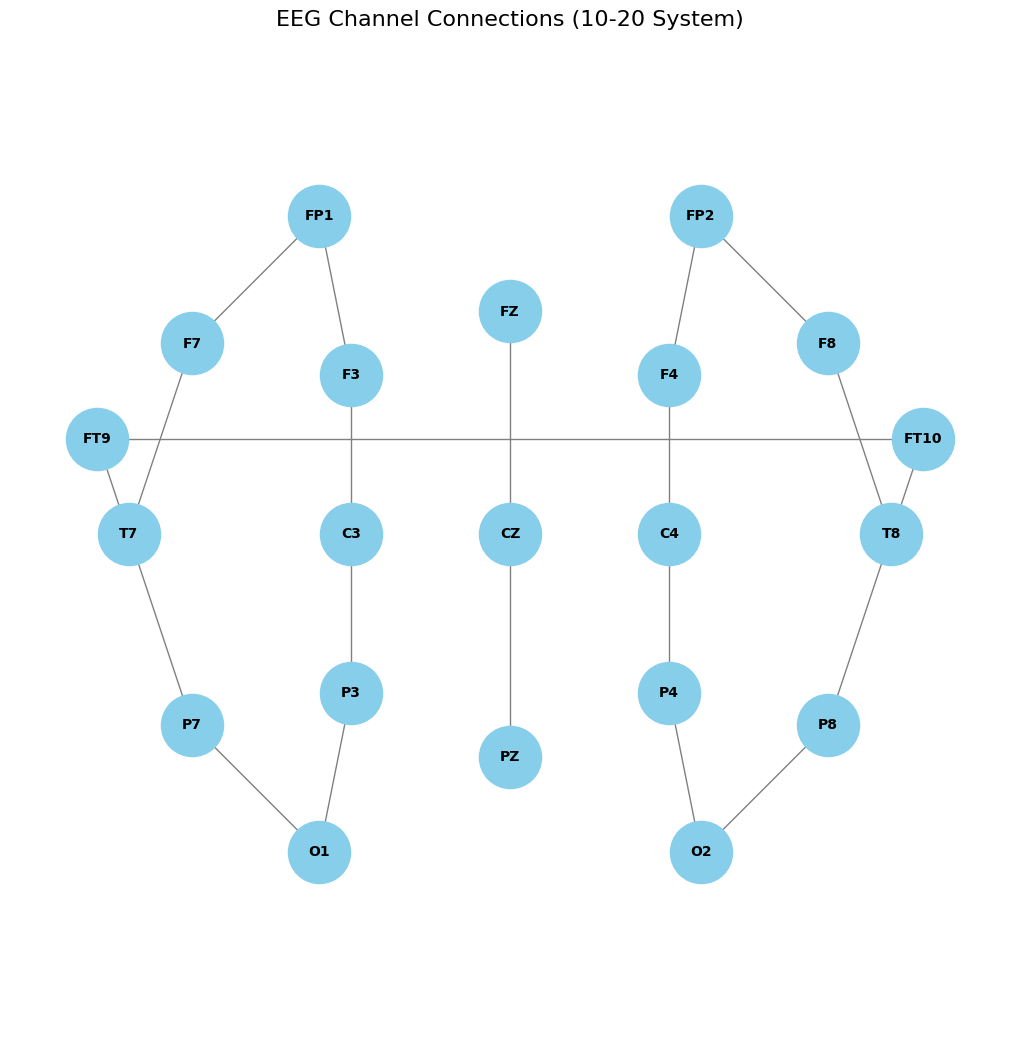

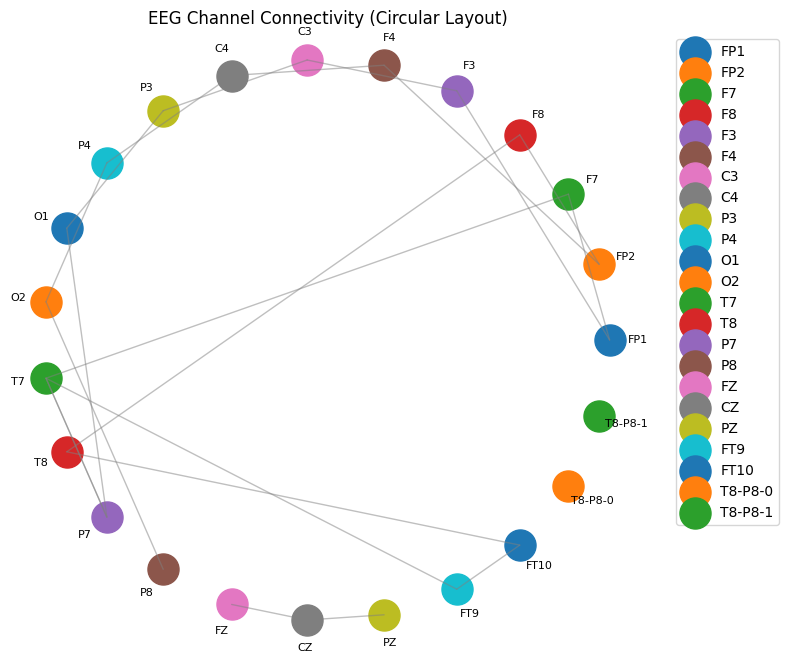

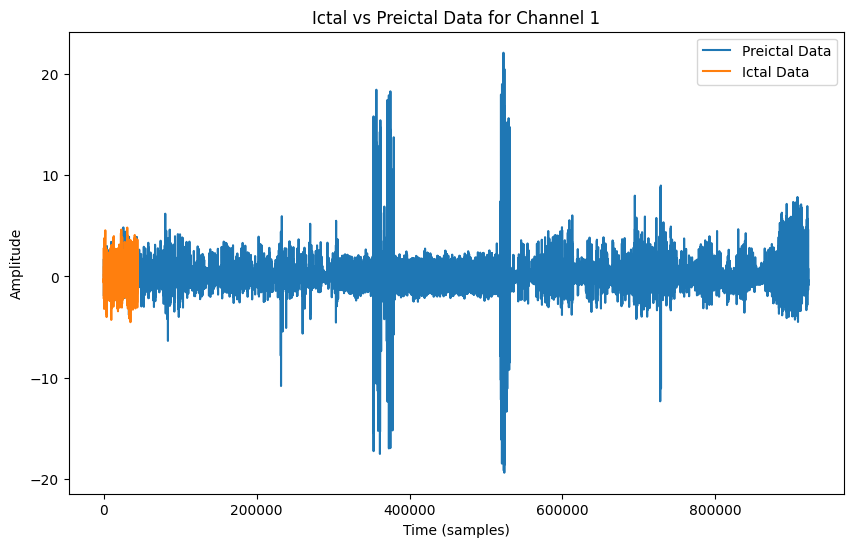

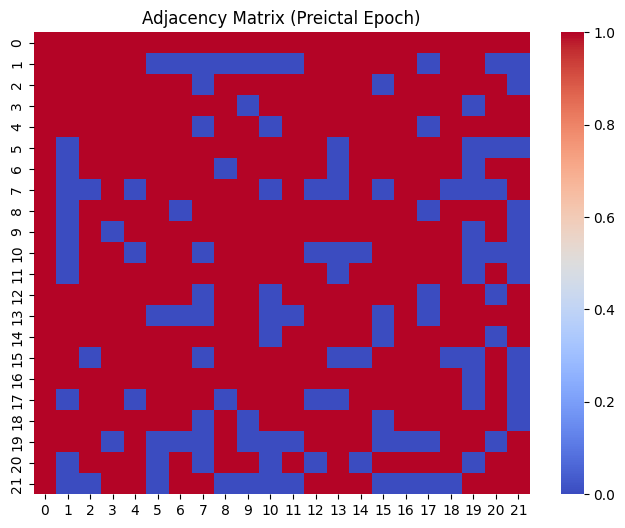

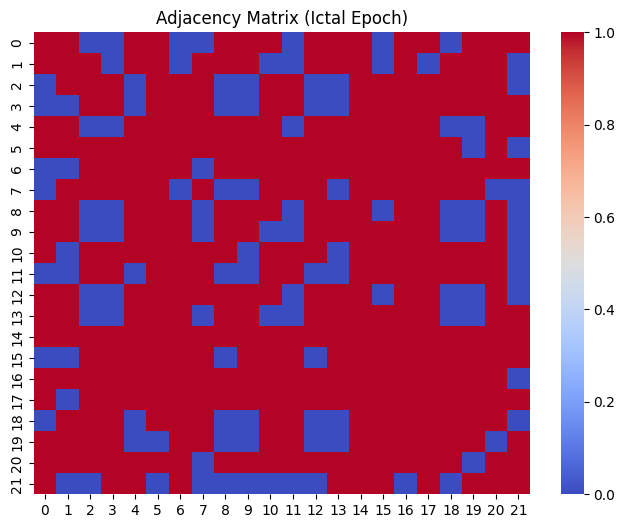

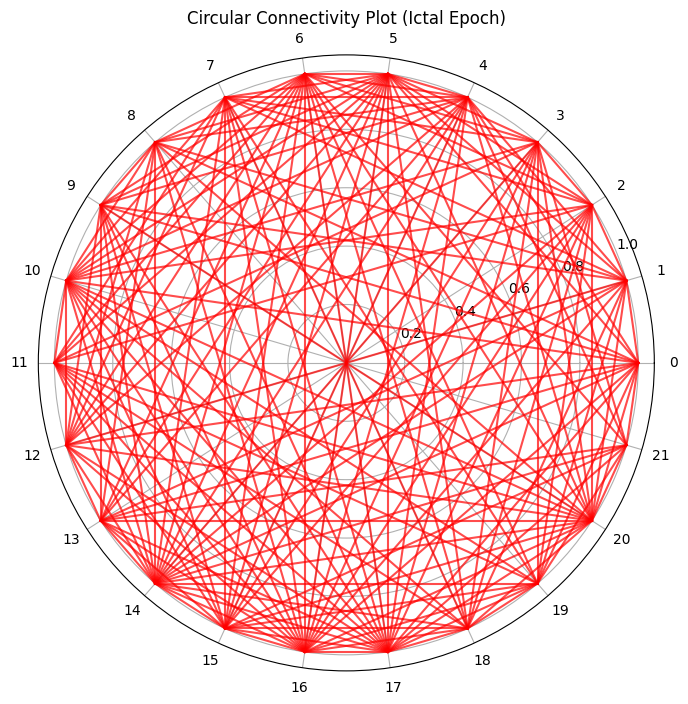

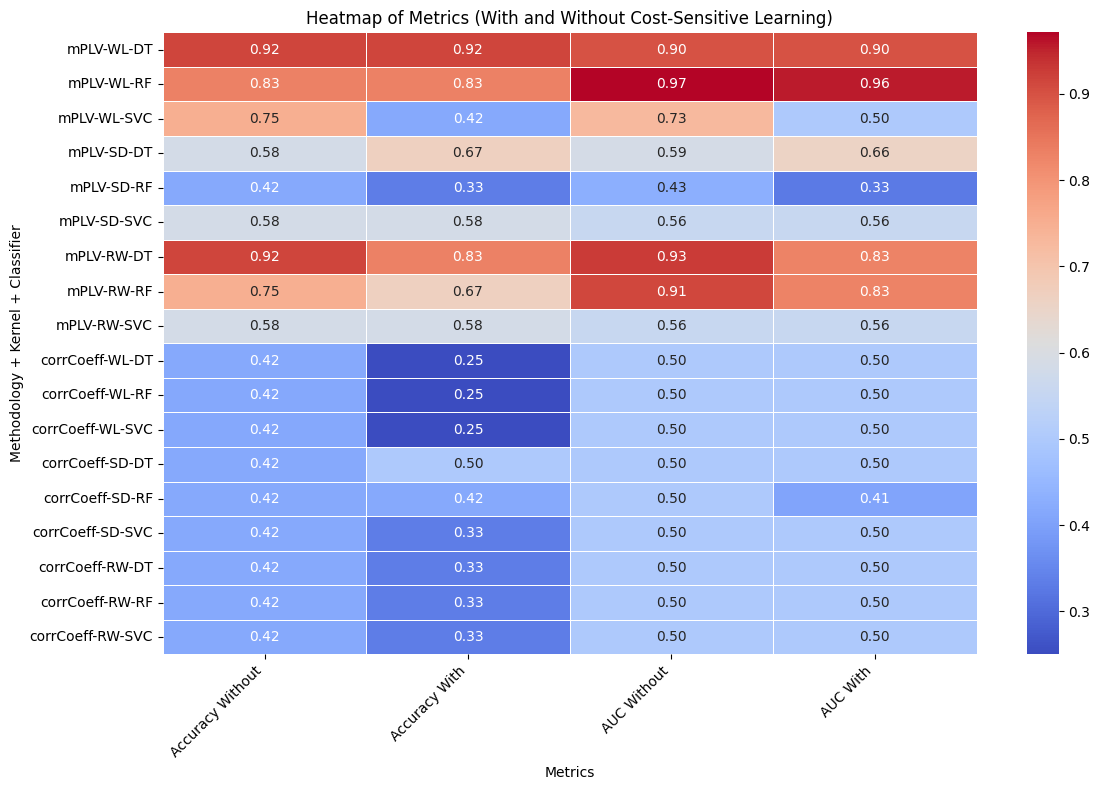

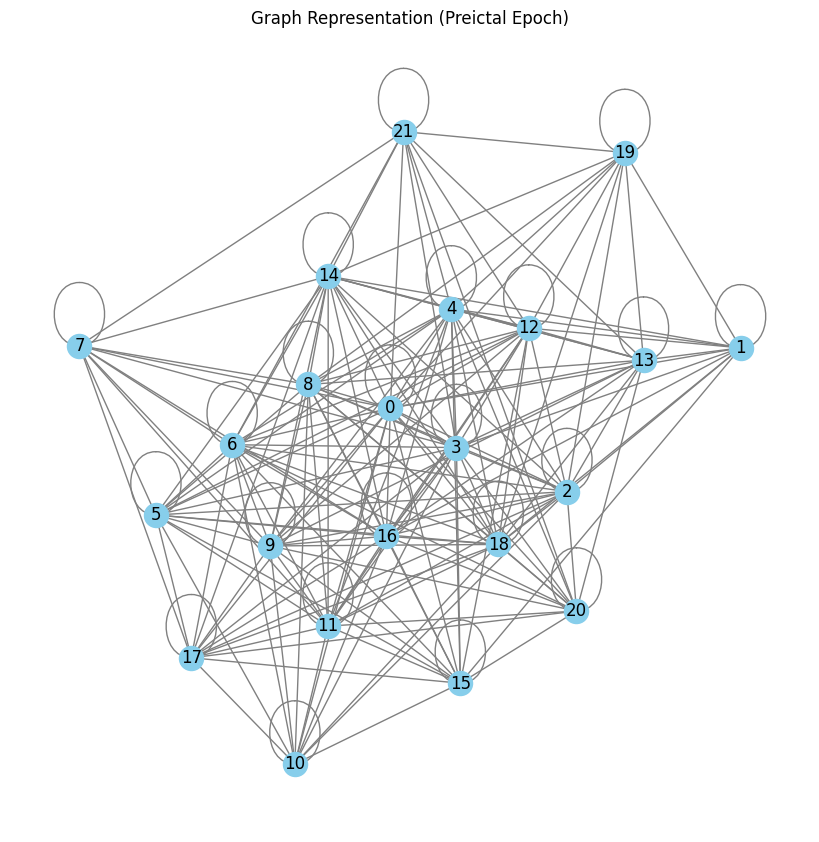

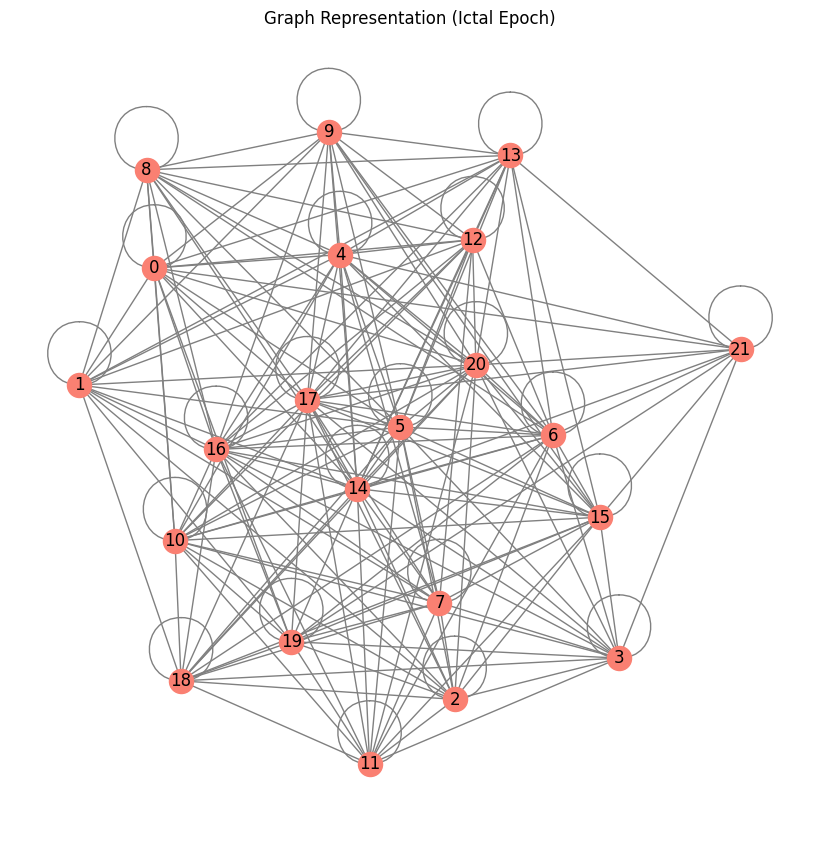

In [22]:
%matplotlib inline
import networkx as nx

# Create a graph from an adjacency matrix (e.g., preictal)
G_preictal = nx.from_numpy_array(adj_matrix[0])
plt.figure(figsize=(8, 8))
nx.draw(G_preictal, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("Graph Representation (Preictal Epoch)")
plt.show()

# Create a graph for an ictal epoch
G_ictal = nx.from_numpy_array(adj_matrix[30])
plt.figure(figsize=(8, 8))
nx.draw(G_ictal, with_labels=True, node_color='salmon', edge_color='gray')
plt.title("Graph Representation (Ictal Epoch)")
plt.show()

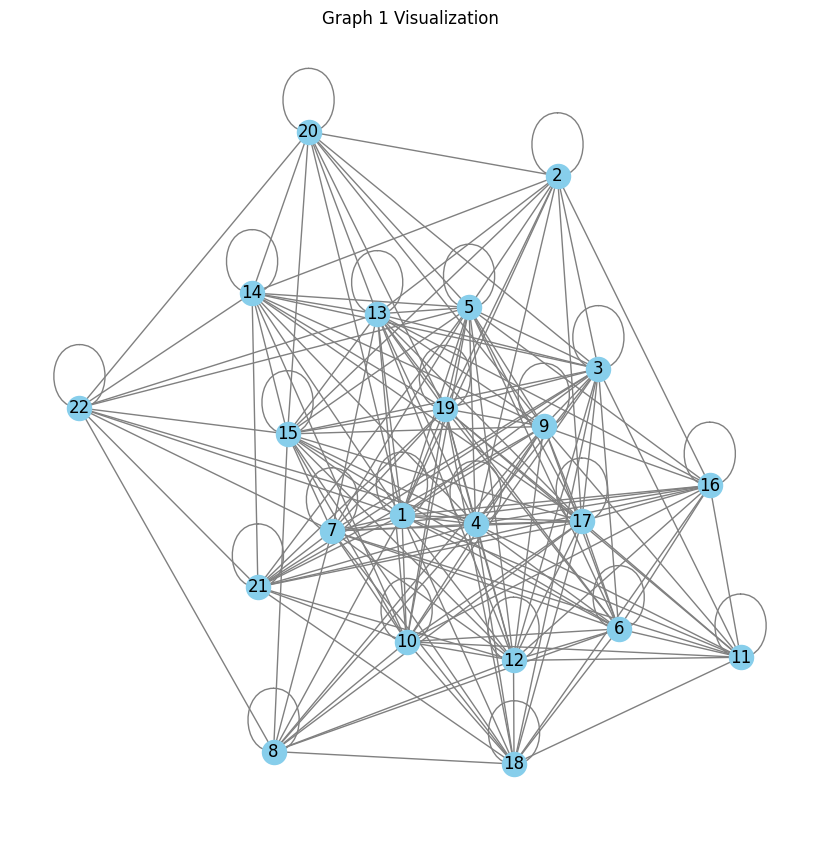

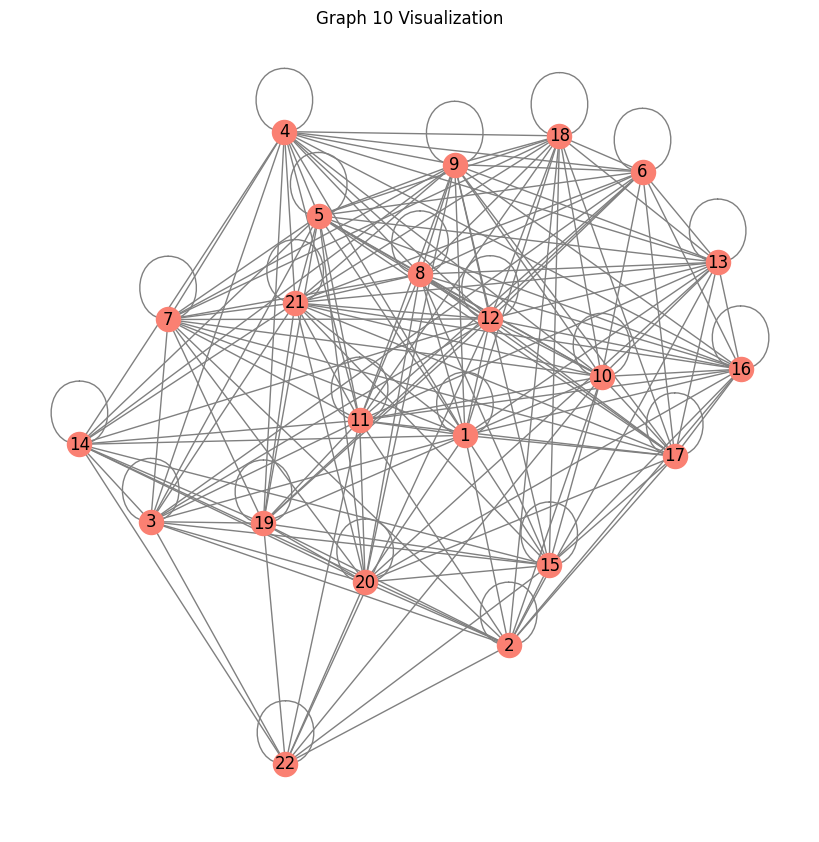

In [23]:
import matplotlib.pyplot as plt
import networkx as nx

# Visualize the first graph
plt.figure(figsize=(8, 8))
nx.draw(graphs[0], with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("Graph 1 Visualization")
plt.show()

# Visualize another graph (e.g., 10th graph)
plt.figure(figsize=(8, 8))
nx.draw(graphs[9], with_labels=True, node_color='salmon', edge_color='gray')
plt.title("Graph 10 Visualization")
plt.show()

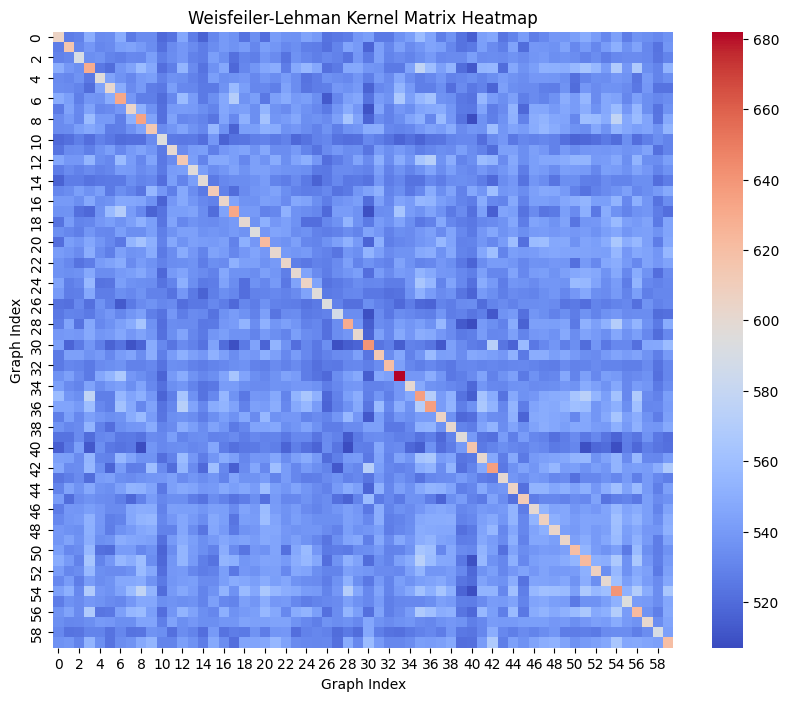

In [24]:
import seaborn as sns
import numpy as np

# Example kernel matrix (replace with your actual kernel_matrix after computation)
# kernel_matrix = np.random.random((len(graphs), len(graphs)))

plt.figure(figsize=(10, 8))
sns.heatmap(kernel_matrix[0], cmap='coolwarm', annot=False)
plt.title("Weisfeiler-Lehman Kernel Matrix Heatmap")
plt.xlabel("Graph Index")
plt.ylabel("Graph Index")
plt.show()

In [27]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Perform clustering on the kernel matrix
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(kernel_matrix[0])

# Use PCA for 2D visualization of the graphs
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(kernel_matrix)

plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    plt.scatter(reduced_data[clusters == cluster_id, 0], reduced_data[clusters == cluster_id, 1], label=f"Cluster {cluster_id + 1}")

plt.title("Graph Clustering Based on Kernel Similarity")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

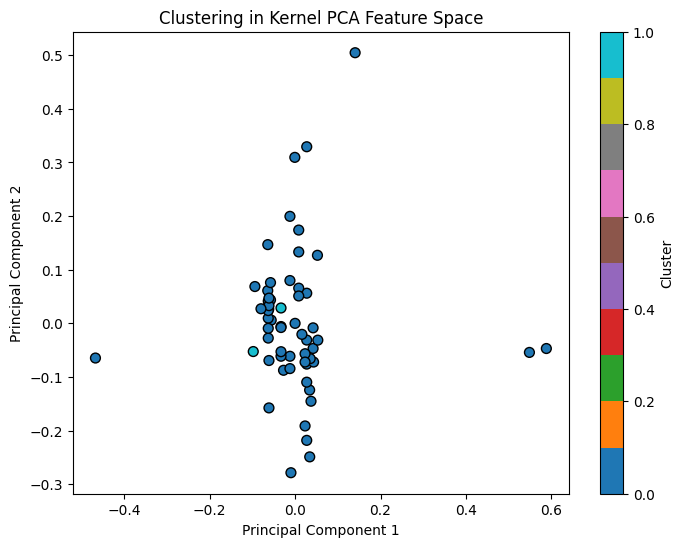

In [28]:
from sklearn.cluster import KMeans

# Fit KMeans clustering on the transformed data
kmeans = KMeans(n_clusters=len(set(y)), random_state=42)
clusters = kmeans.fit_predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='tab10', edgecolor='k', s=50)
plt.title("Clustering in Kernel PCA Feature Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

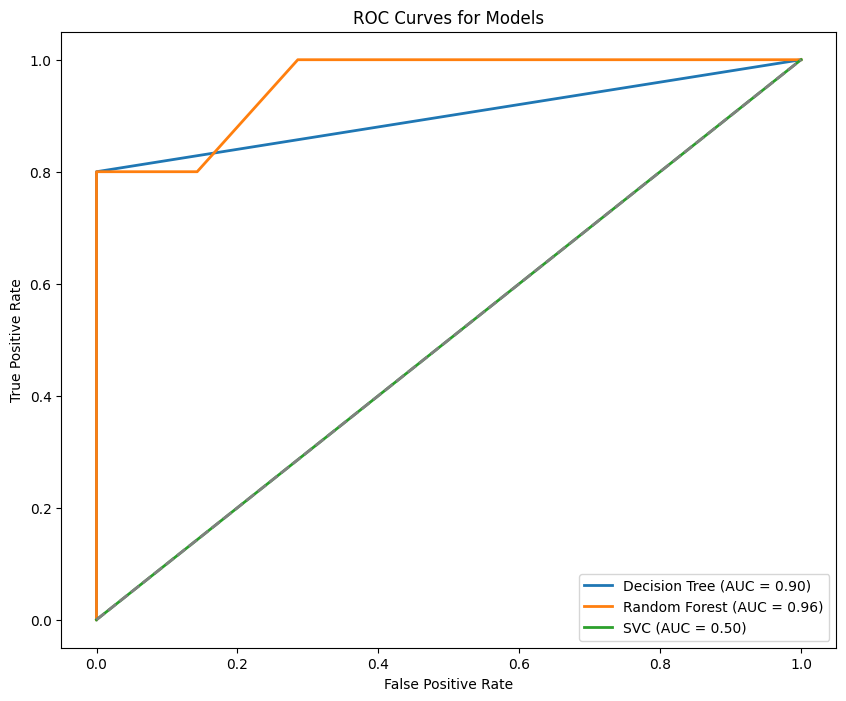

In [29]:
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models')
plt.legend(loc='lower right')
plt.show()


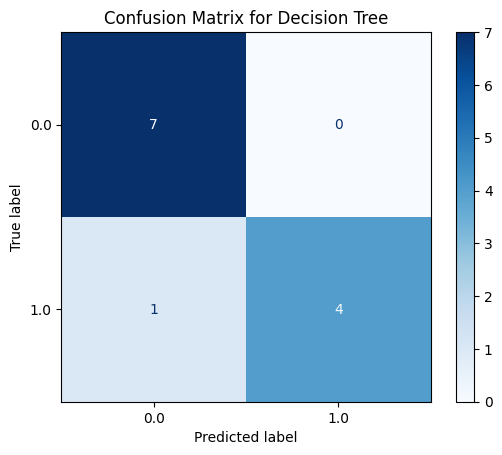

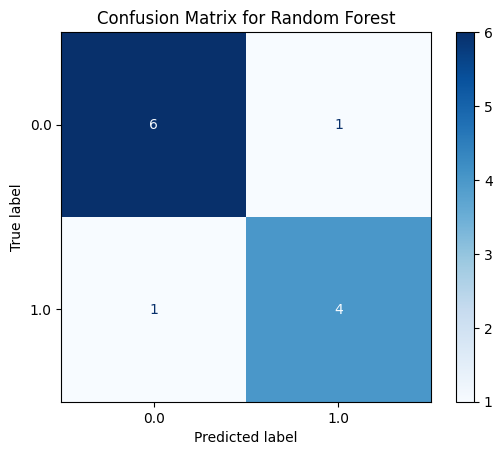

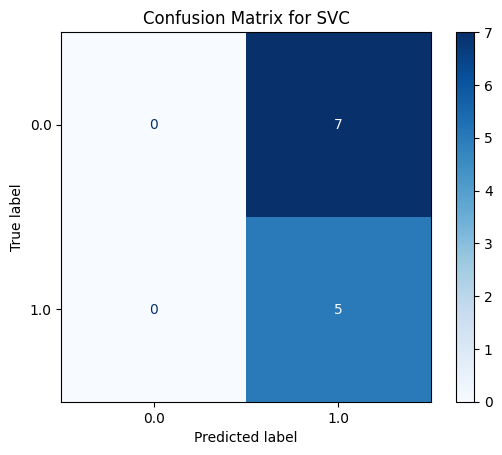

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for name, model in models.items():
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

In [31]:

# final_transform = kpca.fit_transform(kernel_matrix[0]) #gram_kpca:HxR containg the PCA eigenvectors of the gram matrix HxH
# print(final_transform.shape) #ndarray of shape (n_samples, n_components)

# #Visualize the eigenvalues returned by kpca to determine the most suitable number of eigenvectors
# # Extract the eigenvalues
# eigenvalues = kpca.eigenvalues_
# # Optional: Plot the eigenvalues
# plt.figure(figsize=(8, 6))
# plt.plot(eigenvalues, marker='o')
# plt.title('Eigenvalues of Kernel PCA')
# plt.xlabel('Index')
# plt.ylabel('Eigenvalue')
# plt.grid(True)
# plt.show()
# plt.savefig('chbeigkpcacorrspctr.png', bbox_inches='tight')


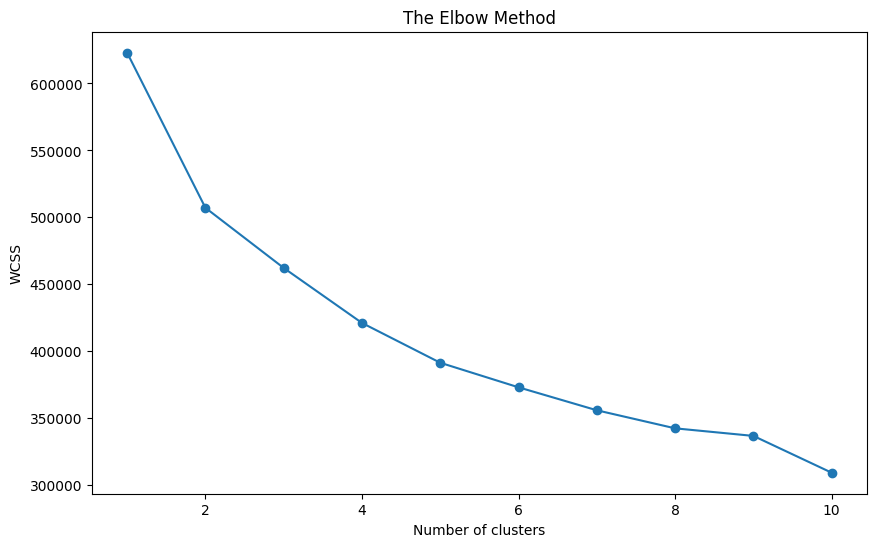

In [32]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=40)
    kmeans.fit(kernel_matrix[0])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [33]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in range(2, 10):  # Test k from 2 to 9
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=40)
    y_kmeans = kmeans.fit_predict(kernel_matrix[0])
    sil_scores.append(silhouette_score(final_transform, y_kmeans))

plt.plot(range(2, 10), sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

NameError: name 'final_transform' is not defined

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_data = pca.fit_transform(kernel_matrix[0])

plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.title("PCA Visualization")
plt.show()

In [36]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

print("Silhouette Score:", silhouette_score(final_transform, y_kmeans))
print("Calinski-Harabasz Score:", calinski_harabasz_score(final_transform, y_kmeans))
print("Davies-Bouldin Index:", davies_bouldin_score(final_transform, y_kmeans))

Silhouette Score: 6.646724741761316e-16
Calinski-Harabasz Score: 0.9999999999999998
Davies-Bouldin Index: 3.588174268580827


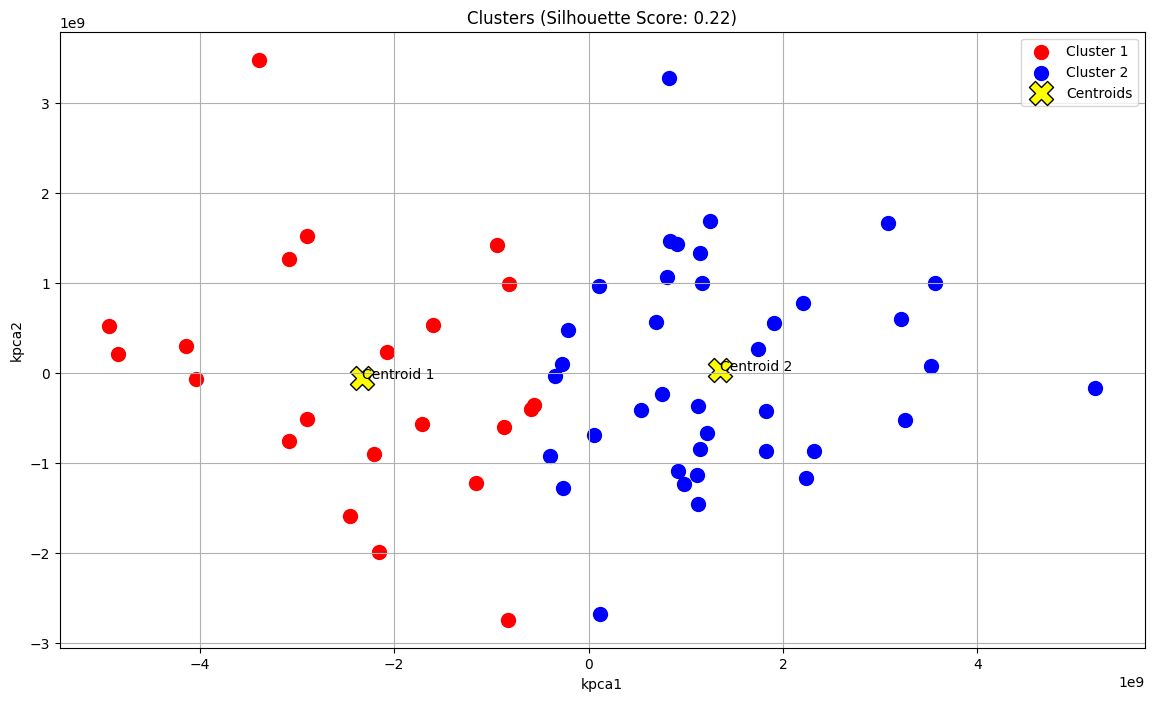

Cluster Sizes:
Cluster 1: 22 points
Cluster 2: 38 points

Silhouette Score: 0.22


In [44]:
from sklearn.metrics import silhouette_score
import numpy as np

# Fit the KMeans model and get centroids

kpca1 = KernelPCA(kernel='poly', gamma=1)


final_transform = kpca1.fit_transform(kernel_matrix[0])
kmeans = KMeans(n_clusters=2, init='random', random_state=40)
y_kmeans = kmeans.fit_predict(final_transform)
centroids = kmeans.cluster_centers_

# Calculate silhouette score
sil_score = silhouette_score(final_transform, y_kmeans)

# Plot enhanced visualization
plt.figure(figsize=(14, 8))
plt.scatter(final_transform[y_kmeans == 0, 0], final_transform[y_kmeans == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(final_transform[y_kmeans == 1, 0], final_transform[y_kmeans == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', marker='X', label='Centroids', edgecolors='black')

# Add annotations
for i, centroid in enumerate(centroids):
    plt.annotate(f'Centroid {i+1}', (centroid[0] + 0.02, centroid[1]), fontsize=10, color='black')

# Add details
plt.title(f'Clusters (Silhouette Score: {sil_score:.2f})')
plt.xlabel('kpca1')
plt.ylabel('kpca2')
plt.grid(True)
plt.legend()
plt.show()

# Print deeper analysis
cluster_sizes = np.bincount(y_kmeans)
print("Cluster Sizes:")
for i, size in enumerate(cluster_sizes):
    print(f"Cluster {i+1}: {size} points")

print(f"\nSilhouette Score: {sil_score:.2f}")

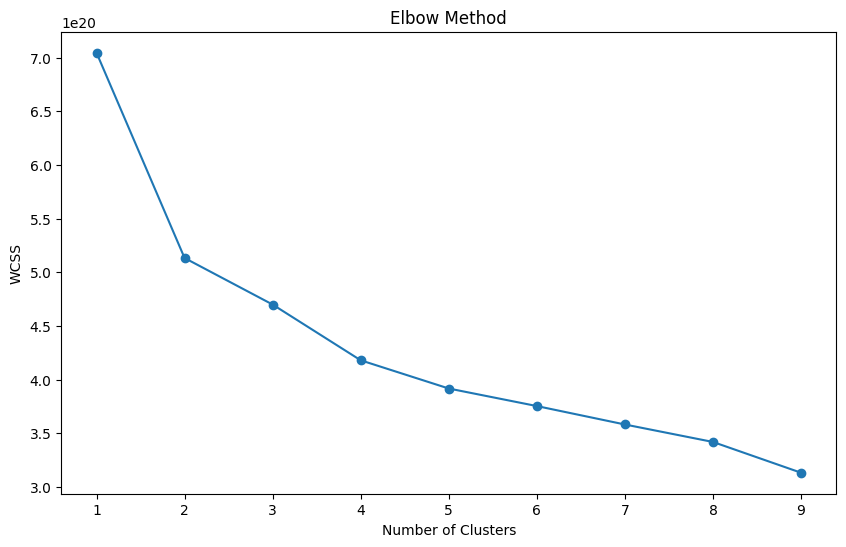

In [66]:
import matplotlib.pyplot as plt

wcss = []
for n in range(1, 10):
    kmeans = KMeans(n_clusters=n, random_state=40)
    kmeans.fit(final_transform)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

RBF Kernel: Silhouette Score = 0.83


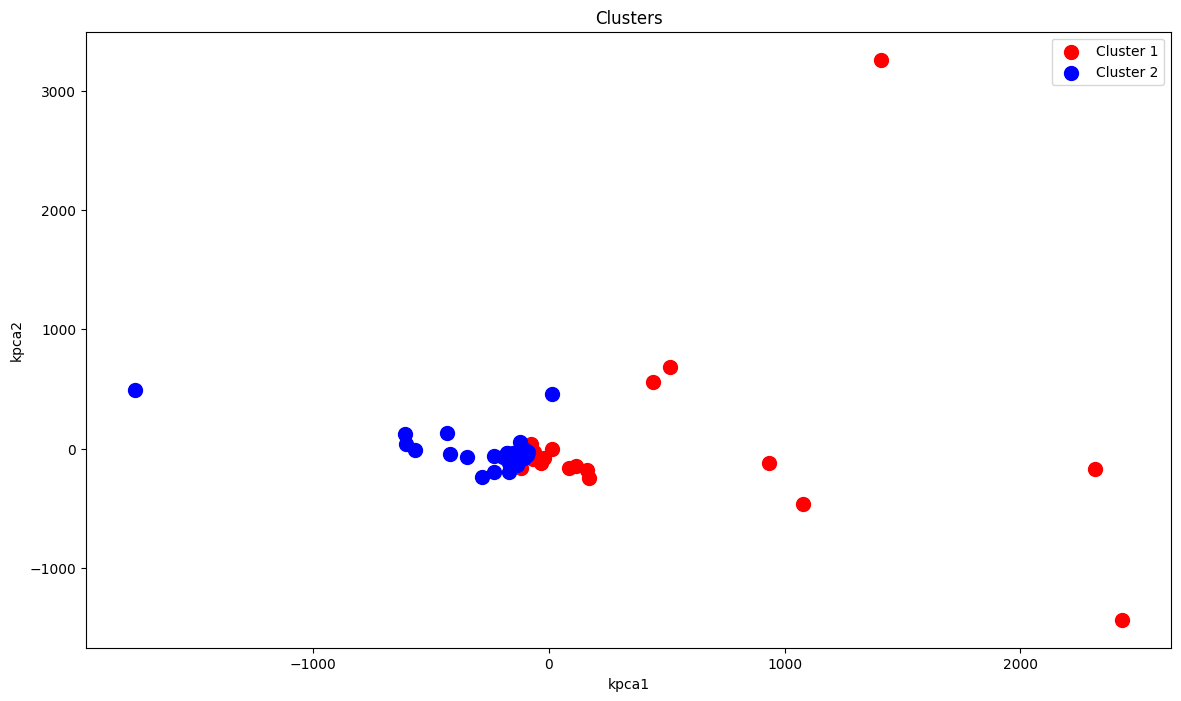

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(kernel_matrix[0])

# kpca = KernelPCA(n_components=2, kernel="rbf", gamma=2)
# transformed_data = kpca.fit_transform(normalized_data)

kpca = KernelPCA(n_components=2, kernel="poly", gamma=2, coef0=1)
transformed_data = kpca.fit_transform(normalized_data)
kmeans = KMeans(n_clusters=2, random_state=40)
labels = kmeans.fit_predict(transformed_data)
sil_score = silhouette_score(transformed_data, labels)
print(f"Poly Kernel: Silhouette Score = {sil_score:.2f}")


plt.figure(figsize=(14, 8))
plt.scatter(transformed_data[y_kmeans == 0, 0], transformed_data[y_kmeans == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(transformed_data[y_kmeans == 1, 0], transformed_data[y_kmeans == 1, 1], s=100, c='blue', label='Cluster 2')
plt.title('Clusters')
plt.xlabel('kpca1')
plt.ylabel('kpca2')
plt.legend()
plt.show()

# param_grid = {'degree': [2, 3, 4]}
# for gamma in param_grid['degree']:
#     kpca = KernelPCA(n_components=2, kernel="poly", gamma=gamma, coef0=1)
#     transformed_data = kpca.fit_transform(normalized_data)
#     kmeans = KMeans(n_clusters=2, random_state=40)
#     labels = kmeans.fit_predict(transformed_data)
#     sil_score = silhouette_score(transformed_data, labels)
#     print(f"RBF Kernel (gamma={gamma}): Silhouette Score = {sil_score:.2f}")

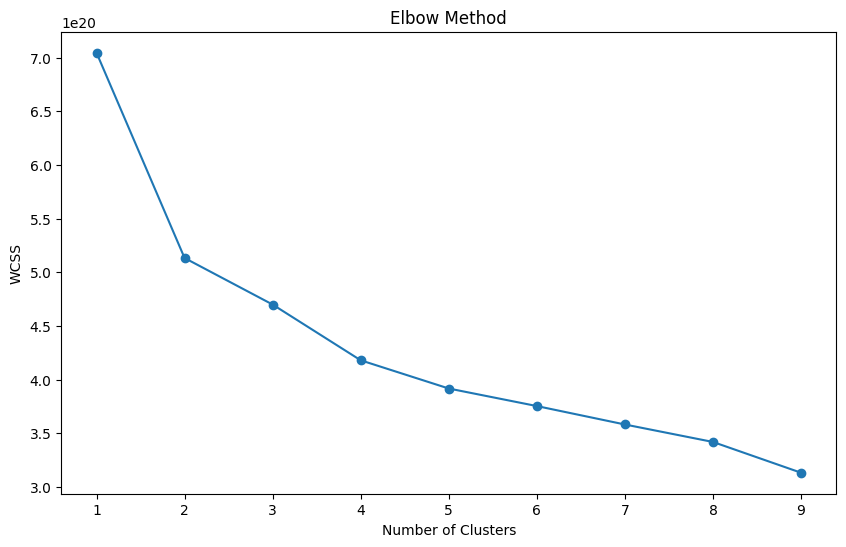

In [87]:
import matplotlib.pyplot as plt

wcss = []
for n in range(1, 10):
    kmeans = KMeans(n_clusters=n, random_state=40)
    kmeans.fit(final_transform)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [ ]:

# Calculate silhouette score
sil_score = silhouette_score(final_transform, y_kmeans)

# Plot enhanced visualization
plt.figure(figsize=(14, 8))
plt.scatter(final_transform[y_kmeans == 0, 0], final_transform[y_kmeans == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(final_transform[y_kmeans == 1, 0], final_transform[y_kmeans == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', marker='X', label='Centroids', edgecolors='black')

# Add annotations
for i, centroid in enumerate(centroids):
    plt.annotate(f'Centroid {i+1}', (centroid[0] + 0.02, centroid[1]), fontsize=10, color='black')

# Add details
plt.title(f'Clusters (Silhouette Score: {sil_score:.2f})')
plt.xlabel('kpca1')
plt.ylabel('kpca2')
plt.grid(True)
plt.legend()
plt.show()

# Print deeper analysis
cluster_sizes = np.bincount(y_kmeans)
print("Cluster Sizes:")
for i, size in enumerate(cluster_sizes):
    print(f"Cluster {i+1}: {size} points")

print(f"\nSilhouette Score: {sil_score:.2f}")

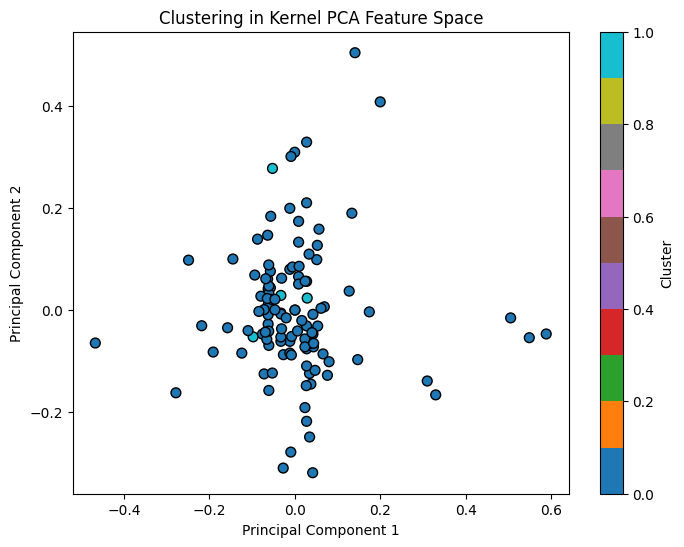

In [86]:
from sklearn.cluster import KMeans

# Fit KMeans clustering on the transformed data
# kmeans = KMeans(n_clusters=len(set(y)), random_state=42)
# clusters = kmeans.fit_predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='tab10', edgecolor='k', s=50)
plt.scatter(X[:, 1], X[:, 2], c=clusters, cmap='tab10', edgecolor='k', s=50)
plt.title("Clustering in Kernel PCA Feature Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()



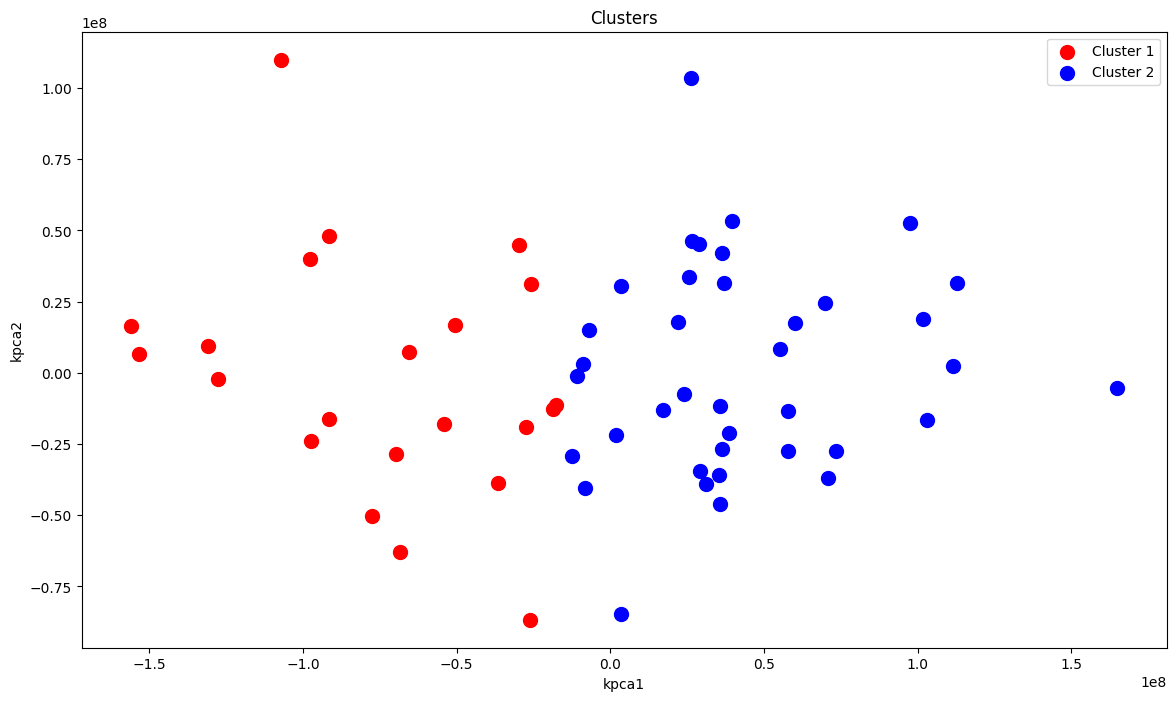


Silhouette Score: 0.22


In [61]:
from sklearn.metrics import silhouette_score
import numpy as np

# Fit the KMeans model and get centroids

kpca1 = KernelPCA(kernel='poly', gamma=0.1, max_iter=3)


# final_transform = kpca1.fit_transform(kernel_matrix[0])
# kmeans = KMeans(n_clusters=2, init='random', random_state=40)
# y_kmeans = kmeans.fit_predict(final_transform)
# centroids = kmeans.cluster_centers_


final_transform1 = kpca1.fit_transform(kernel_matrix[0])
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=40)
y_kmeans = kmeans.fit_predict(final_transform1)

plt.figure(figsize=(14, 8))
plt.scatter(final_transform1[y_kmeans == 0, 0], final_transform1[y_kmeans == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(final_transform1[y_kmeans == 1, 0], final_transform1[y_kmeans == 1, 1], s=100, c='blue', label='Cluster 2')
plt.title('Clusters')
plt.xlabel('kpca1')
plt.ylabel('kpca2')
plt.legend()
plt.show()


# Calculate silhouette score
sil_score = silhouette_score(final_transform1, y_kmeans)


print(f"\nSilhouette Score: {sil_score:.2f}")

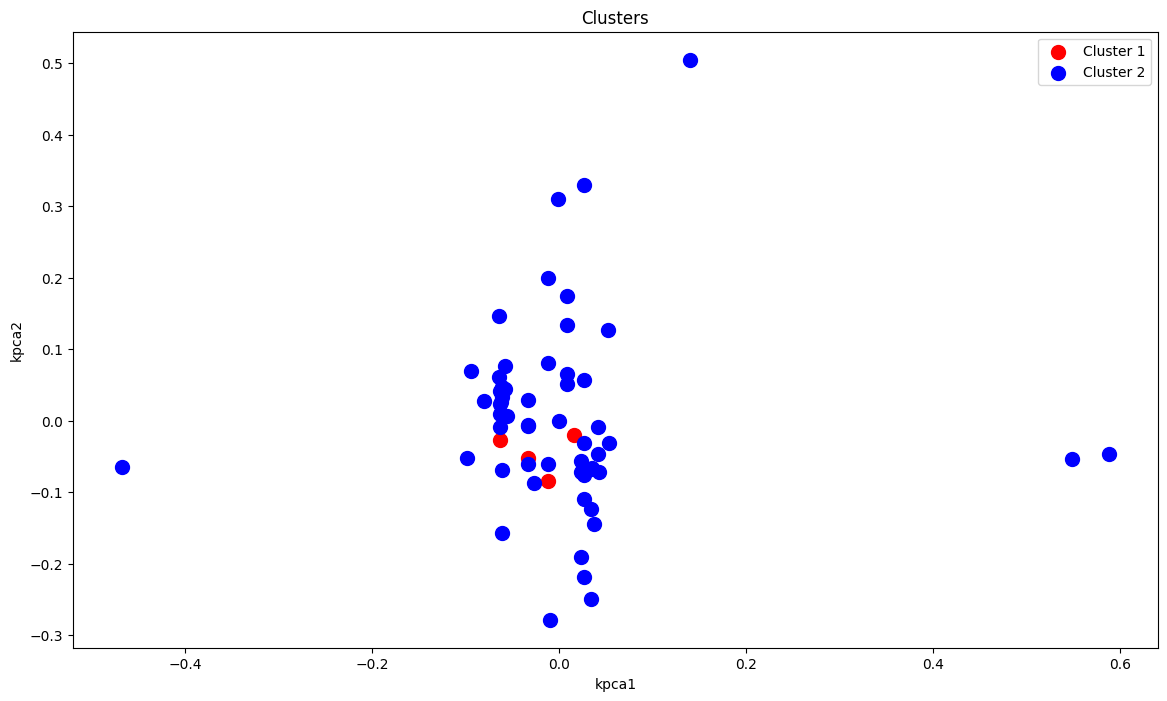

In [34]:

final_transform = kpca.fit_transform(kernel_matrix[0])
kmeans = KMeans(n_clusters=2, init='random', random_state=40)
y_kmeans = kmeans.fit_predict(final_transform)

plt.figure(figsize=(14, 8))
plt.scatter(final_transform[y_kmeans == 0, 0], final_transform[y_kmeans == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(final_transform[y_kmeans == 1, 0], final_transform[y_kmeans == 1, 1], s=100, c='blue', label='Cluster 2')
plt.title('Clusters')
plt.xlabel('kpca1')
plt.ylabel('kpca2')
plt.legend()
plt.show()